In [5]:
import tensorflow as tf

class cond_normal_channel(tf.keras.Model):
    def __init__(self):
        super().__init__()

    def __call__(self, x, no, batch_size, n_coherence, n_antennas, h=None, C=None):
        if h is None or C is None:
            h, C = channel_generation(batch_size, n_coherence, n_antennas)


        noise_real = tf.random.normal(h.shape[1:], dtype=tf.float32)
        noise_imag = tf.random.normal(h.shape[1:], dtype=tf.float32)

        # Create complex noise
        noise = tf.complex(noise_real, noise_imag)

        # Broadcast the complex noise to the batch size
        n = tf.broadcast_to(noise, shape=(batch_size,) + noise.shape)

        n = n / tf.cast(tf.sqrt(no / 2.0), dtype=tf.complex64)
        
        y = h * x + n
                
        return y, h, C

In [6]:
import tensorflow as tf

class equalizer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def __call__(self, h_hat, y, no):
               
        norm_h_hat_squared = tf.reduce_sum(tf.square(tf.abs(h_hat)), axis=-1)
                        
        no_new = tf.math.divide_no_nan(
            no,
            norm_h_hat_squared
        )
                        
        inner_product_h_y = tf.reduce_sum(tf.matmul(y, tf.linalg.adjoint(h_hat)), axis=-1)
                                                
        x_hat = tf.math.divide_no_nan(
            inner_product_h_y,
            tf.cast(norm_h_hat_squared, dtype=tf.complex64)
        )
                        
        return x_hat, no_new


In [14]:
import tensorflow as tf

class genie_mmse_estimator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def __call__(self, y, no, C, pilot):
                
        # noise_var = no^2 * I. Be careful of the data types!
        noise_var = tf.cast(tf.square(no) * tf.eye(C.shape[0]), dtype=tf.complex64)
        
        noise_var = tf.broadcast_to(noise_var, shape=[tf.shape(y)[0], noise_var.shape[0], noise_var.shape[1]])
        
        # scaled_C = |p|^2 * C. Be careful of the data types!
        scaled_C = tf.math.abs(pilot) ** 2 * C
        
        # inverse = (scaled_C + noise_var)^-1. Be careful of the data types!
        inverse = tf.linalg.inv(tf.cast(scaled_C, dtype=tf.complex64) + noise_var)
        
        # scaled_C_2 = conj(p) * C
        scaled_C_2 = tf.math.conj(pilot) * C
        
        # matrix = scaled_C_2 * inverse with shape (1, matrix_size, matrix_size)
        matrix = tf.matmul(tf.cast(scaled_C_2, dtype=tf.complex64), inverse)
                
        y_transpose = tf.transpose(y, perm=[0, 2, 1])
                                
        # h_hat_mmse = (scaled_C_2 * inverse) * y. Be careful of the data types!
        h_hat_mmse = tf.matmul(matrix, y_transpose)
                                
        return tf.transpose(h_hat_mmse, perm=[0, 2, 1])

In [15]:
import tensorflow as tf

class ls_estimator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def __call__(self, h, x):
        h_hat_ls = tf.math.divide_no_nan(h, x)
                
        return h_hat_ls

In [16]:
"""
Various helper functions.

Note:
    The functions are in alphabetical order.
"""
import numpy as np


def batch_kron(a: np.ndarray, b: np.ndarray):
    """
    Batch Kronecker product: np.kron(a[i, :, :], b[i, :, :]) for all i.
    """
    return np.einsum('bik,bjl->bijkl', a, b).reshape(a.shape[0], a.shape[1] * b.shape[1], a.shape[2] * b.shape[2])


def cov2cov(matrices: np.ndarray):
    """
    Convert the real representations of complex covariance matrices back to
    complex representations.
    """
    if matrices.ndim == 2:
        # the case of diagonal matrices
        n_mats, n_diag = matrices.shape
        mats = np.zeros([n_mats, n_diag, n_diag])
        for i in range(n_mats):
            mats[i, :, :] = np.diag(matrices[i, :])
    else:
        mats = matrices

    n_mats, rows, columns = mats.shape
    row_half = rows // 2
    column_half = columns // 2
    covs = np.zeros((n_mats, row_half, column_half), dtype=complex)
    for c in range(n_mats):
        upper_left_block = mats[c, :row_half, :column_half]
        upper_right_block = mats[c, :row_half, column_half:]
        lower_left_block = mats[c, row_half:, :column_half]
        lower_right_block = mats[c, row_half:, column_half:]
        covs[c, :, :] = upper_left_block + lower_right_block + 1j * (lower_left_block - upper_right_block)
    return covs


def cplx2real(vec: np.ndarray, axis=0):
    """
    Concatenate real and imaginary parts of vec along axis=axis.
    """
    return np.concatenate([vec.real, vec.imag], axis=axis)


def crandn(*arg, rng=np.random.default_rng()):
    return np.sqrt(0.5) * (rng.standard_normal(arg) + 1j * rng.standard_normal(arg))


def kron_approx_sep_ls(
    mats_A: np.ndarray,
    init_C: np.ndarray,
    rows_B: int,
    cols_B: int,
    iterations: int = 10
):
    """
    Approximate a matrix in terms of a Kronecker product of two matrices. The
    array init_C is an initialization for the matrix C and will be overwritten.
    If it is structured, for example, if it is positive definite, then the
    returned matrices B and C will have the same structure. Section 5 of the
    source explains what kind of structure can be used.

    Note:
        This corresponds to Framework 2 in Section 4 in the source.

    Source:
        "Approximation with Kronecker Products"
        by Van Loan, Pitsianis
        https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.1924&rep=rep1&type=pdf
    """
    if mats_A.ndim == 2:
        mats_A = np.expand_dims(mats_A, 0)
        init_C = np.expand_dims(init_C, 0)

    mats_B = np.zeros((mats_A.shape[0], rows_B, cols_B), dtype=mats_A.dtype)
    mats_C = init_C
    rows_C, cols_C = mats_C.shape[-2:]

    # Extract the blocks A_ij: Split the 3d array of shape (n, rows_B * rows_C, cols_B * cols_C) into a 5d array of
    # shape (n, rows_B, cols_B, rows_C, cols_C) where [:, i, j, :, :] corresponds to the blocks A_ij in equation (2).
    blocks_A = np.zeros((mats_A.shape[0], rows_B, cols_B, rows_C, cols_C), dtype=mats_A.dtype)
    for i, block_row in enumerate(np.split(mats_A, rows_B, axis=-2)):
        for j, block in enumerate(np.split(block_row, cols_B, axis=-1)):
            blocks_A[:, i, j, :, :] = block

    # Extract the blocks Ahat_ij: Split the 3d array of shape (n, rows_B * rows_C, cols_B * cols_C) into a 5d array of
    # shape (n, rows_C, cols_C, rows_B, cols_B) where [:, i, j, :, :] corresponds to the blocks Ahat_ij in equation (4).
    blocks_Ahat = np.zeros((mats_A.shape[0], rows_C, cols_C, rows_B, cols_B), dtype=mats_A.dtype)
    for i in range(rows_C):
        for j in range(cols_C):
            blocks_Ahat[:, i, j, :, :] = \
                mats_A[:, i: i + (rows_B - 1) * rows_C + 1: rows_C, j: j + (cols_B - 1) * cols_C + 1: cols_C]

    beta_or_gamma = np.zeros((mats_A.shape[0], 1, 1), dtype=mats_A.dtype)

    def project(blocks_ij, b_or_c, c_or_b_out):
        """
        For every block A_ij (or Ahat_ij), compute equation (8) (or (9)) in Theorem 4.1.
        """
        np.einsum('ijklm,ilm->ijk', blocks_ij, b_or_c, out=c_or_b_out)
        np.einsum('ijk,ijk->i', b_or_c, b_or_c, out=beta_or_gamma[:, 0, 0])
        c_or_b_out /= beta_or_gamma

    for _ in range(iterations):
        project(blocks_A, mats_C, mats_B)
        project(blocks_Ahat, mats_B, mats_C)

    return mats_B, mats_C


def kron_approx_svd(mats_A: np.ndarray, rows_B: int, cols_B: int, rows_C: int, cols_C: int):
    r"""
    Approximate a matrix in terms of a Kronecker product of two matrices.

    Note:
        Given a matrix A, find matrices B and C of shapes (rows_B, cols_B) and
        (rows_C, cols_C) such that \| A - B \otimes C \|_F is minimized.
        If A is structured, e.g., symmetric or positive definite, the function
        kron_approx_sep_ls can be used.

    Source:
        "Approximation with Kronecker Products"
        by Van Loan, Pitsianis
        https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.1924&rep=rep1&type=pdf
    """
    if mats_A.ndim == 2:
        mats_A = np.expand_dims(mats_A, 0)
    n, rows_A, cols_A = mats_A.shape
    if rows_B * rows_C != rows_A:
        raise ValueError(f'rows_B*rows_C = {rows_A} is required, but rows_B*rows_C = {rows_B*rows_C}')
    if cols_B * cols_C != cols_A:
        raise ValueError(f'cols_B*cols_C = {cols_A} is required, but cols_B*cols_C = {cols_B*cols_C}')

    def block(A, i, j):
        """
        Extract block A_ij from the matrix A. Every block A_ij has shape
        (rows_C, cols_C) and there are rows_B * cols_B such blocks.
        """
        return A[i * rows_C: (i + 1) * rows_C, j * cols_C: (j + 1) * cols_C]

    out_B = np.zeros((n, rows_B, cols_B), dtype=mats_A.dtype)
    out_C = np.zeros((n, rows_C, cols_C), dtype=mats_A.dtype)
    for ni in range(n):
        # the following implements equation (5)
        rearranged_A = np.zeros((rows_B * cols_B, rows_C * cols_C), dtype=mats_A.dtype)
        for j in range(cols_B):
            # extract the matrix A_j
            rearranged_A[j * rows_B: (j + 1) * rows_B, :] = np.concatenate(
                [block(mats_A[ni, :, :], i, j).flatten('F')[np.newaxis, :] for i in range(rows_B)],
                axis=0
            )
        u, s, vh = np.linalg.svd(rearranged_A)
        out_B[ni, :, :] = u[:, 0].reshape(rows_B, cols_B, order='F') * s[0]
        out_C[ni, :, :] = vh[0, :].reshape(rows_C, cols_C, order='F')
    return out_B, out_C


def kron_real(mats1: np.ndarray, mats2: np.ndarray):
    """
    Assuming mats1 and mats2 are real representations of complex covariance
    matrices, compute the real representation of the Kronecker product of the
    complex covariance matrices.
    """
    if mats1.ndim != mats2.ndim:
        raise ValueError(
            'The two arrays need to have the same number of dimensions, '
            f'but we have mats1.ndim = {mats1.ndim} and mats2.ndim = {mats2.ndim}.'
        )
    if mats1.ndim == 2:
        mats1 = np.expand_dims(mats1, 0)
        mats2 = np.expand_dims(mats2, 0)

    n = mats1.shape[0]
    rows1, cols1 = mats1.shape[-2:]
    rows2, cols2 = mats2.shape[-2:]
    row_half1 = rows1 // 2
    column_half1 = cols1 // 2
    row_half2 = rows2 // 2
    column_half2 = cols2 // 2
    rows3 = 2 * row_half1 * row_half2
    cols3 = 2 * column_half1 * column_half2

    out_kron_prod = np.zeros((n, rows3, cols3))
    for i in range(n):
        A1 = mats1[i, :row_half1, :column_half1]
        B1 = mats1[i, :row_half1, column_half1:]
        C1 = mats1[i, row_half1:, :column_half1]
        D1 = mats1[i, row_half1:, column_half1:]

        A2 = mats2[i, :row_half2, :column_half2]
        B2 = mats2[i, :row_half2, column_half2:]
        C2 = mats2[i, row_half2:, :column_half2]
        D2 = mats2[i, row_half2:, column_half2:]

        A = np.kron(A1 + D1, A2 + D2)
        D = -np.kron(C1 - B1, C2 - B2)
        B = -np.kron(A1 + D1, C2 - B2)
        C = np.kron(C1 - B1, A2 + D2)

        A = 0.5 * (A + D)
        D = A
        B = 0.5 * (B - C)
        C = -B

        out_kron_prod[i, :, :] = np.concatenate(
            (np.concatenate((A, B), axis=1), np.concatenate((C, D), axis=1)),
            axis=0
        )
    return np.squeeze(out_kron_prod)


def mat2bsc(mat: np.ndarray):
    """
    Arrange the real and imaginary parts of a complex matrix mat in block-
    skew-circulant form.

    Source:
        See https://ieeexplore.ieee.org/document/7018089.
    """
    upper_half = np.concatenate((mat.real, -mat.imag), axis=-1)
    lower_half = np.concatenate((mat.imag, mat.real), axis=-1)
    return np.concatenate((upper_half, lower_half), axis=-2)


def real2real(mats):
    re = np.real(mats)
    im = np.imag(mats)
    rows = mats.shape[1]
    cols = mats.shape[2]
    out = np.zeros([mats.shape[0], 2*rows, 2*cols])
    out[:, :rows, :cols] = 0.5*re
    out[:, rows:, cols:] = 0.5*re
    return out


def imag2imag(mats):
    im = np.real(mats)
    rows = mats.shape[1]
    cols = mats.shape[2]
    out = np.zeros([mats.shape[0], 2*rows, 2*cols])
    #out[:, :rows, :cols] = 0.5*re
    for i in range(mats.shape[0]):
        out[i, :rows, cols:] = 0.5*im[i,:,:].T
        out[i, rows:, :cols] = 0.5*im[i,:,:]
    #out[:, rows:, cols:] = 0.5*re
    return out


def nmse(actual: np.ndarray, desired: np.ndarray):
    """
    Mean squared error between actual and desired divided by the total number
    of elements.
    """
    mse = 0
    for i in range(actual.shape[0]):
        mse += np.linalg.norm(actual - desired) ** 2 / np.linalg.norm(desired) ** 2
    return mse / actual.shape[0]
    #return np.sum(np.abs(actual - desired) ** 2) / desired.size


def real2cplx(vec: np.ndarray, axis=0):
    """
    Assume vec consists of concatenated real and imaginary parts. Return the
    corresponding complex vector. Split along axis=axis.
    """
    re, im = np.split(vec, 2, axis=axis)
    return re + 1j * im


def sec2hours(seconds: float):
    """"
    Convert a number of seconds to a string h:mm:ss.
    """
    # hours
    h = seconds // 3600
    # remaining seconds
    r = seconds % 3600
    return '{:.0f}:{:02.0f}:{:02.0f}'.format(h, r // 60, r % 60)

def check_random_state(seed):
    import numbers
    """Turn seed into a np.random.RandomState instance

    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

def print_dict(dict: dict, entries_per_row: int=1):
    """Print the keys and values of dictionary dict."""
    if entries_per_row < 1:
        raise ValueError(f'The number of entries per row needs to be >= 1 but is {entries_per_row}')
    for c, (key, value) in enumerate(dict.items()):
        if c % entries_per_row == 0 and c > 0:
            print()
        else:
            c > 0 and print(' | ', end='')
        print('{}: {}'.format(key, value), end='')
    print()


def dft_matrix(n_antennas, n_grid):
    grid = np.linspace(-1, 1, n_grid + 1)[:n_grid]

    d = 1 / np.sqrt(n_antennas) * np.exp(1j * np.pi * np.outer(np.arange(n_antennas), grid.conj().T))
    return d

#def dist_fac(n_bits: int):
#    """"Compute distortion factor for an arbitrary number of bits."""
#    if n_bits == 1:
#        raise ValueError('The distortion factor for 1-bit is known in closed form.')
#    else:
#        return n_bits * 2**(-2*n_bits)

In [17]:
import numpy as np

def scm_channel(
    angles,
    weights,
    n_coherence,
    n_antennas,
    sigma=2.0,
    rng=np.random.default_rng()
):
    (h, t) = chan_from_spectrum(n_coherence, n_antennas, angles, weights, sigma, rng=rng)
    return h, t


def spectrum(u, angles, weights, sigma=2.0):
    u = (u + np.pi) % (2 * np.pi) - np.pi
    theta = np.degrees(np.arcsin(u / np.pi))
    v = _laplace(theta, angles, weights, sigma) \
        + _laplace(180 - theta, angles, weights, sigma)

    return np.degrees(2 * np.pi * v / np.sqrt(np.pi ** 2 - u ** 2))


def _laplace(theta, angles, weights, sigma=2.0):
    # The variance \sigma^2 of a Laplace density is \sigma^2 = 2 * scale_parameter^2.
    # Hence, the standard deviation \sigma is \sigma = sqrt(2) * scale_parameter.
    # The scale_parameter determines the Laplace density.
    # For an angular spread (AS) given in terms of a standard deviation \sigma
    # the scale parameter thus needs to be computed as scale_parameter = \sigma / sqrt(2)
    scale_parameter = sigma / np.sqrt(2)
    x_shifted = np.outer(theta, np.ones(angles.size)) - angles
    x_shifted = (x_shifted + 180) % 360 - 180
    v = weights / (2 * scale_parameter) * np.exp(-np.absolute(x_shifted) / scale_parameter)
    return v.sum(axis=1)


def chan_from_spectrum(
    n_coherence,
    n_antennas,
    angles,
    weights,
    sigma=2.0,
    rng=np.random.default_rng()
):

    o_f = 100  # oversampling factor (ideally, would use continuous freq. spectrum...)
    n_freq_samples = o_f * n_antennas

    # Sample the spectrum which is defined in equation (78) with epsilon, try
    # to avoid sampling at -pi and pi, thus avoiding dividing by zero.
    epsilon = 1 / 3
    lattice = np.arange(epsilon, n_freq_samples+epsilon) / n_freq_samples * 2 * np.pi - np.pi #sampled between -pi,+pi
    fs = spectrum(lattice, angles, weights, sigma)
    fs = np.reshape(fs, [len(fs), 1])

    # Avoid instabilities due to almost infinite energy at some frequencies
    # (this should only happen at "endfire" of a uniform linear array where --
    # because of the arcsin-transform -- the angular psd grows to infinity).
    almost_inf_threshold = np.max([1, n_freq_samples])  # use n_freq_samples as threshold value...
    almost_inf_freqs = np.absolute(fs) > almost_inf_threshold
    # this should not/only rarely be entered due to the epsilon above; one might even want to increase the threshold
    # to, e.g., 30 * almost_inf_threshold

    # if any(np.absolute(fs) > 20 * almost_inf_threshold):
    #     print("almost inf: ", fs[almost_inf_freqs])

    fs[almost_inf_freqs] = almost_inf_threshold  # * np.exp(1j * np.angle(fs[almost_inf_freqs])) # only real values

    if np.sum(fs) > 0:
        fs = fs / np.sum(fs) * n_freq_samples  # normalize energy

    x = crandn(n_freq_samples, n_coherence, rng=rng)

    h = np.fft.ifft(np.sqrt(fs)*x, axis=0) * np.sqrt(n_freq_samples)
    h = h[0:n_antennas, :]

    # t is the first row of the covariance matrix of h (which is Toeplitz and Hermitian)
    t = np.fft.fft(fs, axis=0) / n_freq_samples
    t = t[0:n_antennas]
    t = np.reshape(t, n_antennas)

    return h.T, t


In [18]:
"""Module to create a multi path channel model.

Classes:
        SCMMulti: Class to build a multi path channel model.

"""
import numpy as np

class SCMMulti:
    """Class to build a multi path channel model.

    This class defines a multi path channel model.

    Public Methods:

    Instance Variables:

    """

    def __init__(self, path_sigma=2.0, n_path=3):
        """Initialize multi path channel model.

        First, initialise all variables belonging to the multi path channel model.
        """
        self.path_sigma = path_sigma
        self.n_path = n_path

    def generate_channel(
        self,
        n_batches,
        n_coherence,
        n_antennas,
        rng=np.random.default_rng()
    ):
        """Generate multi path model parameters.

        Returns:
            A tuple (h, t) consisting of channels h with
                h.shape = (n_batches, n_coherence, n_antennas)
            and the first rows t of the covariance matrices with
                t.shape = (n_batches, n_antennas)
        """

        h = np.zeros([n_batches, n_coherence, n_antennas], dtype=np.complex64)
        t = np.zeros([n_batches, n_antennas], dtype=np.complex64)

        for i in range(n_batches):
            gains = rng.random(self.n_path)
            gains = gains / np.sum(gains, axis=0)
            angles = (rng.random(self.n_path) - 0.5) * 180

            h[i, :, :], t[i, :] = scm_channel(angles, gains, n_coherence, n_antennas, self.path_sigma, rng=rng)

        return h, t

    def get_config(self):
        config = {
            'path_sigma': self.path_sigma,
            'n_path': self.n_path
        }
        return config

In [19]:
from scipy.linalg import toeplitz
import numpy as np

def channel_generation(batch_size, n_coherences, n_antennas):
    """
    SIMO version.
    """
    path_sigma = 2.0
    n_path = 1
    channel = SCMMulti(path_sigma=path_sigma, n_path=n_path)

    # generate channel samples with certain batch size
    rng = np.random.default_rng(1235428719812346)

    h, t = channel.generate_channel(batch_size, n_coherences, n_antennas, rng)

    # full covariance matrix of first sample
    C = toeplitz(t[0, :])

    print('Generated ' + str(batch_size) + ' SIMO channel samples of size ' + str(n_antennas) + 'x1.')
    
    return h, C

In [20]:
try:
    import sionna as sn
except AttributeError:
    import sionna as sn
import tensorflow as tf

class end2endModel(tf.keras.Model):

    def __init__(self, num_bits_per_symbol, block_length, n_coherence, n_antennas, genie_estimator):
        super().__init__()

        self.genie_estimator = genie_estimator
        
        self.n_coherence = n_coherence
        self.n_antennas = n_antennas
        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.channel = cond_normal_channel()
        
        self.ls_estimator = ls_estimator()
        self.mmse_estimator = genie_mmse_estimator()
        
        self.equalizer = equalizer()
        
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation, num_bits_per_symbol=self.num_bits_per_symbol)
        
    def __call__(self, batch_size, ebno_db):
        
        #pilot phase
        
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
                                
        pilot = tf.ones((batch_size, 1, 1), dtype=tf.complex64)
                        
        y_p, h, C = self.channel(pilot, no, batch_size, self.n_coherence, self.n_antennas)
        
        h_hat_ls = self.ls_estimator(h, pilot)
        
        h_hat_mmse = self.mmse_estimator(y_p, no, C, pilot)
        
        #uplink phase
        
        #x_data = all x except x[0][0] (x has shape (1, 512))
        x_data = x[:, 1:]
        
                        
        y = []
        x_hat_ls = []
        x_hat_mmse = []
        no_ls_new = []
        no_mmse_new = []
        llr_ls = tf.zeros((batch_size, 2, 0), dtype=tf.float32)
        llr_mmse = tf.zeros((batch_size, 2, 0), dtype=tf.float32)
                
        for i in range(tf.shape(x_data)[1]):
            #y = h * x + n for all x except first one
            y_i = self.channel(x_data[0][i], no, batch_size, self.n_coherence, self.n_antennas, h, C)[0]
            y.append(y_i)
        
            x_hat_ls_i, no_ls_new_i = self.equalizer(h_hat_ls, y_i, no)
            x_hat_ls.append(x_hat_ls_i)
            no_ls_new.append(no_ls_new_i)

            x_hat_mmse_i, no_mmse_new_i = self.equalizer(h_hat_mmse, y_i, no)
            x_hat_mmse.append(x_hat_mmse_i)
            no_mmse_new.append(no_mmse_new_i)
            
            llr_ls_i = self.demapper([x_hat_ls_i, no_ls_new_i])
            llr_ls = tf.concat([llr_ls, tf.reshape(llr_ls_i, (batch_size, 2, 1))], axis=2)
            
            llr_mmse_i = self.demapper([x_hat_mmse_i, no_mmse_new_i])
            llr_mmse = tf.concat([llr_mmse, tf.reshape(llr_mmse_i, (batch_size, 2, 1))], axis=2)
            
        bits = bits[:, self.num_bits_per_symbol:]
        
        llr_ls = tf.reshape(llr_ls, bits.shape)
        llr_mmse = tf.reshape(llr_mmse, bits.shape)

        if self.genie_estimator:
            return bits, llr_mmse
        
        return bits, llr_ls

Generated tf.Tensor(1024, shape=(), dtype=int32) SIMO channel samples of size 32x1.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_math_ops.py:6577: ComplexWarning: Casting complex values to real discards the imaginary part
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 5.0027e-01 | 1.0000e+00 |      523545 |     1046528 |         1024 |        1024 |         9.2 |reached target block errors
Generated tf.Tensor(1024, shape=(), dtype=int32) SIMO channel samples of size 32x1.
   -8.947 | 5.0041e-01 | 1.0000e+00 |      523693 |     1046528 |         1024 |        1024 |         9.4 |reached target block errors
Generated tf.Tensor(1024, shape=(), dtype=int32) SIMO channel samples of size 32x1.
   -7.895 | 4.9981e-01 | 1.0000e+00 |      523066 |     1046528 |         1024 |        1024 |         9.6 |reached target block errors
Generated tf.Tensor(1024, shape=(), dtype=int32) SIMO channel samples of size 32x1.
   -6.842 | 5.0023e-01 | 1.0000e+00 |      523504 |     1046528 |         1024 |     

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([0.50026851, 0.50040993, 0.4998108 , 0.50022933, 0.50009938,
        0.50031151, 0.49960918, 0.50045675, 0.50027615, 0.50058766,
        0.49940279, 0.50044528, 0.49936074, 0.50040706, 0.49954994,
        0.50044719, 0.50038891, 0.50033157, 0.50000956, 0.50007358])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])>)

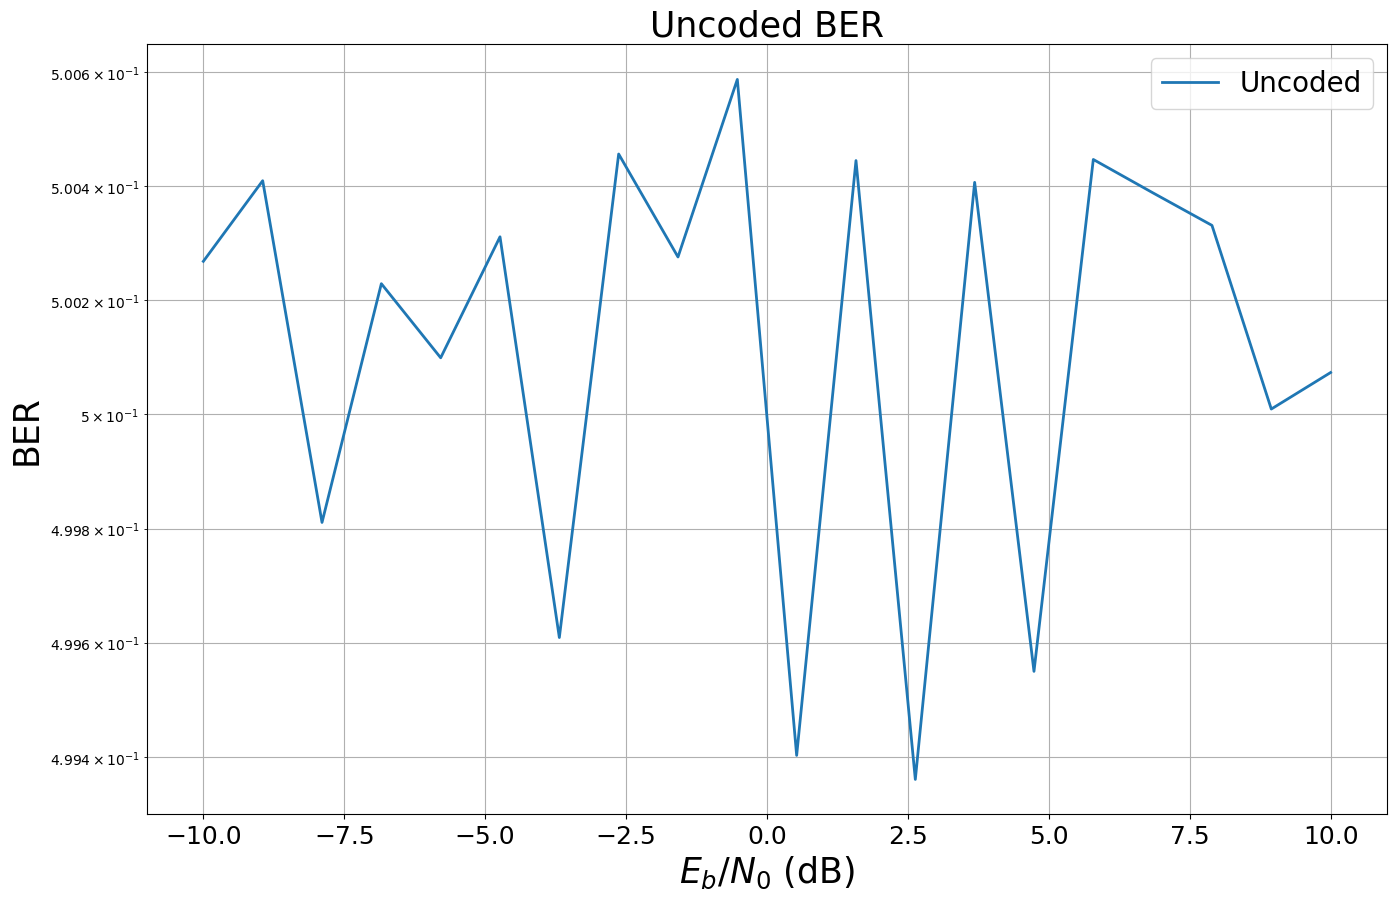

In [21]:
num_bits_per_symbol = 2
block_length = 1024
ebno_db_min = -10.0 # Minimum value of Eb/N0 [dB] for simulations
ebno_db_max = 10.0 # Maximum value of Eb/N0 [dB] for simulations
batch_size = 1024 # How many examples are processed by Sionna in parallel
n_coherence = 1
n_antennas = 32
genie_estimator = False
    
uncoded_e2e_model = end2endModel(num_bits_per_symbol=num_bits_per_symbol, block_length=block_length, n_coherence=n_coherence, n_antennas=n_antennas, genie_estimator=genie_estimator)
    
ber_plots = sn.utils.PlotBER("Uncoded BER")
ber_plots.simulate(
    uncoded_e2e_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 20),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="Uncoded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=True   
)